# Teaching Physics to an AI

In this Notebook, I will run simple physics simulations, and then show how neural networks can be used to "learn" or predict future states in the simulation.

In [19]:
import time
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import pylab as py

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

## Double Pendulum Equations of Motion

<img src="img/double-pendulum.png" width="100px" />

$$
F = ma = -kx
$$

with the initial conditions of $x(0) = 1$ and $v(0) = x^\prime(0) = 0$.


### Computational Solution

Writing this as an ODE:
$$
x^{\prime\prime} = -\frac{k}{m}x
$$

Scipy's ODE solver can solve any system of first order ODEs, so we will rewrite this 2nd-order ODE as a system of first-order ODEs:
$$
\begin{align}
x_1^\prime &= x_2 \\
x_2^\prime &= -\frac{k}{m}x_1
\end{align}
$$

Now let's code this up in Python.

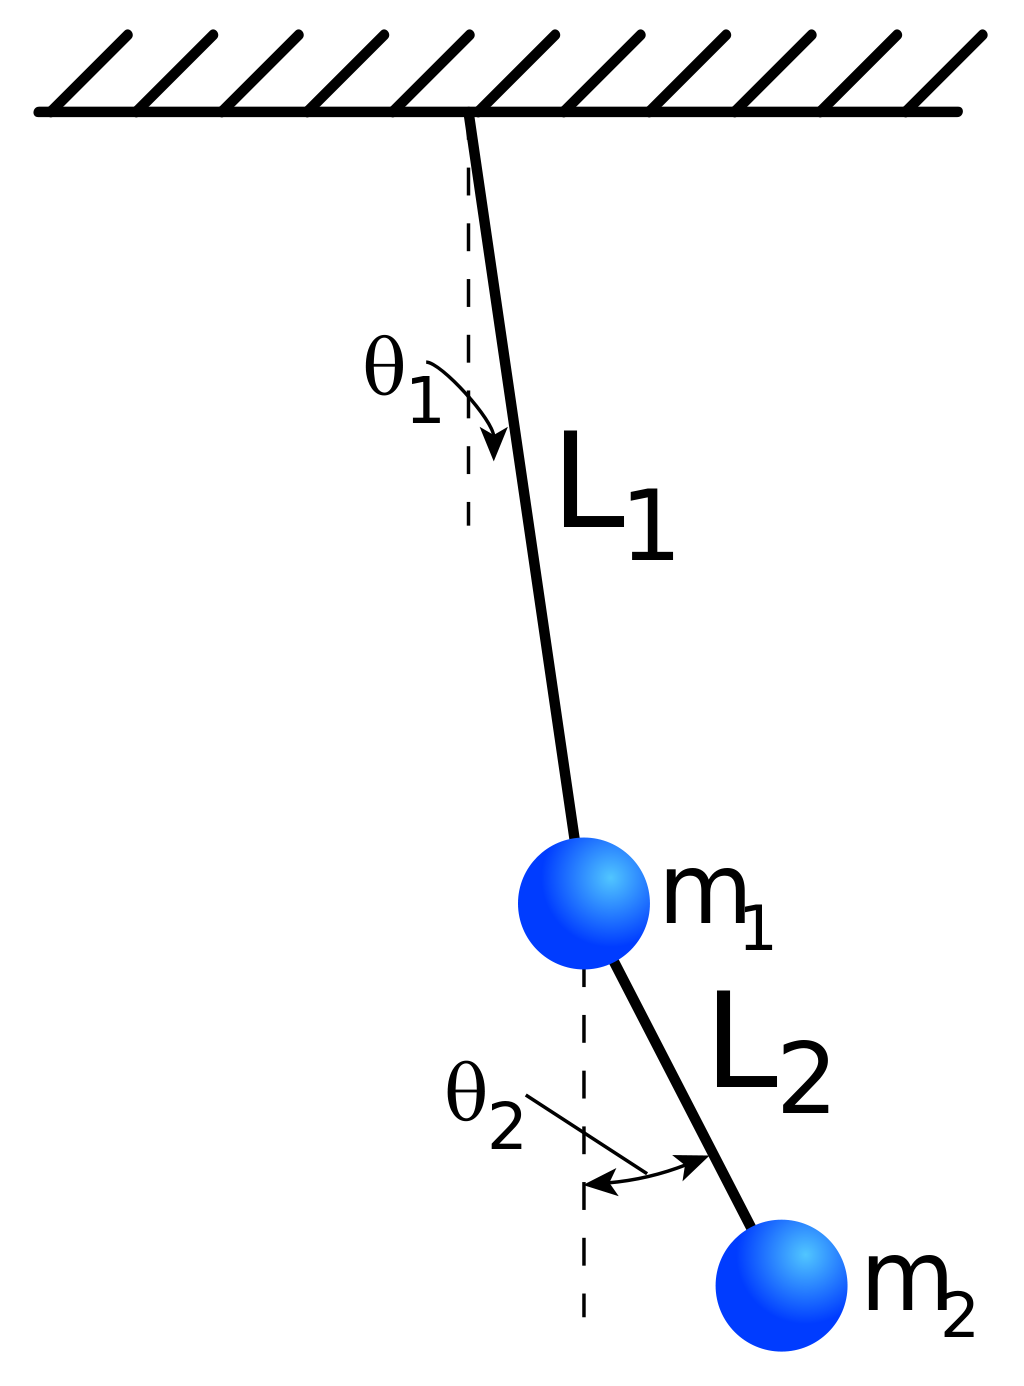

In [22]:
Image("double-pendulum.png")

In [3]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                 # mass of pendulum 2 (in kg)
L1 = 1.4               # length of pendulum 1 (in meter)
L2 = 1                 # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

u0 = [-np.pi/2.2, 0, np.pi/1.8, 0]    # initial conditions. 
# u[0] = angle of the first pendulum
# u[1] = angular velocity of the first pendulum
# u[2] = angle of the second pendulum
# u[3] = angular velocity of the second pendulum

tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
Nt = 751
t = np.linspace(0, tfinal, Nt)

In [4]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
  
    
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    
    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du

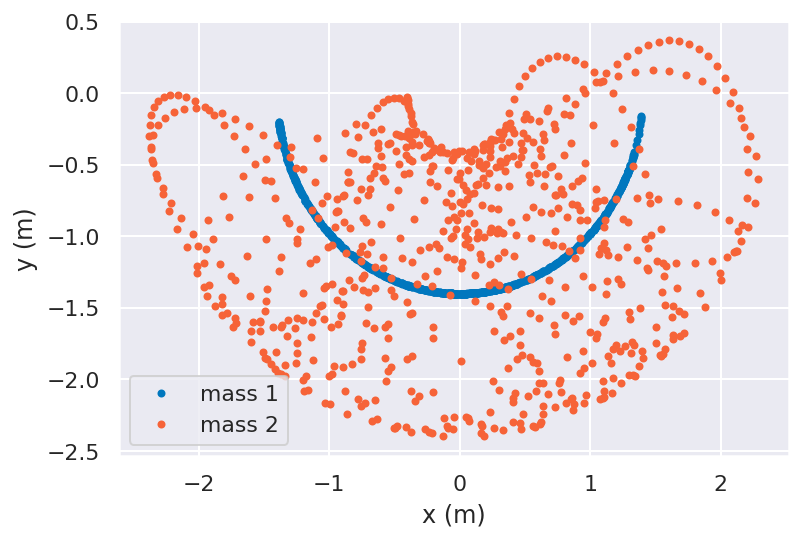

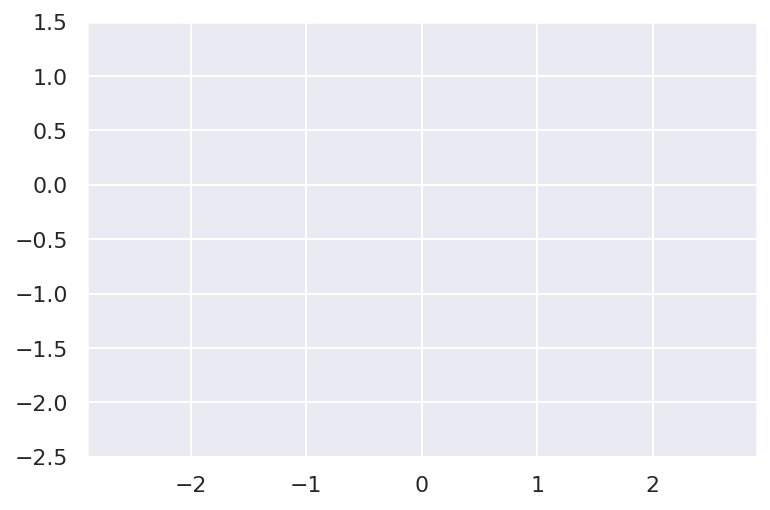

In [5]:
sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))


#sol[:,0] = u1 = Θ_1
#sol[:,1] = u2 = ω_1
#sol[:,2] = u3 = Θ_2
#sol[:,3] = u4 = ω_2
u0 = sol[:,0]     # theta_1 
u1 = sol[:,1]     # omega 1
u2 = sol[:,2]     # theta_2 
u3 = sol[:,3]     # omega_2 


# Mapping from polar to Cartesian
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);

x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);


py.close('all')

py.figure(1)
#py.plot(t,x1)
#py.plot(t,y1)
py.plot(x1,y1,'.',color = '#0077BE',label = 'mass 1')
py.plot(x2,y2,'.',color = '#f66338',label = 'mass 2' )
py.legend()
py.xlabel('x (m)')
py.ylabel('y (m)')

#py.figure(2)
#py.plot(t,x2)
#py.plot(t,y2)


fig = plt.figure()
ax = plt.axes(xlim=(-L1-L2-0.5, L1+L2+0.5), ylim=(-2.5, 1.5))
#line, = ax.plot([], [], lw=2,,markersize = 9, markerfacecolor = "#FDB813",markeredgecolor ="#FD7813")
line1, = ax.plot([], [], 'o-',color = '#d2eeff',markersize = 12, markerfacecolor = '#0077BE',lw=2, markevery=10000, markeredgecolor = 'k')   # line for Earth
line2, = ax.plot([], [], 'o-',color = '#ffebd8',markersize = 12, markerfacecolor = '#f66338',lw=2, markevery=10000, markeredgecolor = 'k')   # line for Jupiter
line3, = ax.plot([], [], color='k', linestyle='-', linewidth=2)
line4, = ax.plot([], [], color='k', linestyle='-', linewidth=2)
line5, = ax.plot([], [], 'o', color='k', markersize = 10)
time_template = 'Time = %.1f s'
time_string = ax.text(0.05, 0.9, '', transform=ax.transAxes)

In [6]:
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    time_string.set_text('')

    
    return  line3,line4, line5, line1, line2, time_string

In [10]:
# animation function.  This is called sequentially
def animate(i):
    # Motion trail sizes. Defined in terms of indices. Length will vary with the time step, dt. E.g. 5 indices will span a lower distance if the time step is reduced.
    trail1 = 6              # length of motion trail of weight 1 
    trail2 = 8              # length of motion trail of weight 2
    
    dt = t[2]-t[1]          # time step
    
    line1.set_data(x1[i:max(1,i-trail1):-1], y1[i:max(1,i-trail1):-1])   # marker + line of first weight
    line2.set_data(x2[i:max(1,i-trail2):-1], y2[i:max(1,i-trail2):-1])   # marker + line of the second weight
    
    line3.set_data([x1[i], x2[i]], [y1[i], y2[i]])       # line connecting weight 2 to weight 1
    line4.set_data([x1[i], 0], [y1[i],0])                # line connecting origin to weight 1
    
    line5.set_data([0, 0], [0, 0])
    time_string.set_text(time_template % (i*dt))
    return  line3, line4,line5,line1, line2, time_string


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=1000*(t[2]-t[1])*0.8, blit=True)

In [15]:
from IPython.display import HTML
HTML(anim.to_html5_video())

### Neural Network Prediction

Now let's show a neural network part of the data from this harmonic oscillator and have it try to predict the rest.